In [1]:
!wget http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip

--2023-01-10 09:42:14--  http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip
Resolving mrl.cs.vsb.cz (mrl.cs.vsb.cz)... 158.196.141.22
Connecting to mrl.cs.vsb.cz (mrl.cs.vsb.cz)|158.196.141.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341866898 (326M) [application/zip]
Saving to: ‘mrlEyes_2018_01.zip’

mrlEyes_2018_01.zip 100%[===================>] 326.03M  7.30MB/s    in 46s     

2023-01-10 09:43:02 (7.15 MB/s) - ‘mrlEyes_2018_01.zip’ saved [341866898/341866898]



In [2]:
!unzip -q mrlEyes_2018_01

In [3]:
import os
BASE_PATH = "mrlEyes_2018_01"

def get_files_labels():
    filenames = []
    labels = []
    images_dirs = [x for x in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, x))]
    for dir in images_dirs:
        new_path = os.path.join(BASE_PATH, dir)
        for img in os.listdir(new_path):
            img_path = os.path.join(BASE_PATH, dir, img)
            filenames.append(img_path)
            eye_closed = img.split("_")[4]
            if eye_closed == "0":
                labels.append(0)
            elif eye_closed == "1":
                labels.append(1)
            else:
                raise Exception("Unknown label")

    return filenames, labels

filenames, labels = get_files_labels()

In [4]:
from sklearn.model_selection import train_test_split

TEST_RATIO = 0.2
VAL_RATIO = 0.15

filenames_train, filenames_test, labels_train, labels_test = train_test_split(filenames, labels, test_size=TEST_RATIO, 
    random_state=42, shuffle=True, stratify=labels)

filenames_train, filenames_val, labels_train, labels_val = train_test_split(filenames_train, labels_train, test_size=VAL_RATIO, 
    random_state=42, shuffle=True, stratify=labels_train)

In [5]:
print("TEST SIZE:", len(filenames_test))
print("TRAIN_SIZE:", "-train:", len(filenames_train), "-val:", len(filenames_val))

TEST SIZE: 16980
TRAIN_SIZE: -train: 57730 -val: 10188


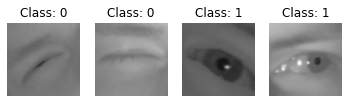

In [10]:
import os
import random

f1 = []
f2 = []

for i, l in enumerate(labels):
    if i<1000:
        continue
    if l == 0 and len(f1)<2:
        f1.append(filenames[i])
    if l == 1 and len(f2)<2:
        f2.append(filenames[i])
    if len(f1) == 2 and len(f2) == 2:
        break

import matplotlib.pyplot as plt
import cv2
for i in range(2):
    plt.subplot(1,4,i+1)
    im = cv2.imread(f1[i])
    im = cv2.resize(im, (640,640))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.axis("off");
    plt.imshow(im)
    plt.title("Class: 0")

for i in range(2):
    plt.subplot(1,4,i+2+1)
    im = cv2.imread(f2[i])
    im = cv2.resize(im, (640,640))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.axis("off");
    plt.imshow(im)
    plt.title("Class: 1")

plt.show()

In [ ]:
import tensorflow as tf

IMAGE_SIZE = 128

def load_image(img_path, label, height, width):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [height, width])
    return image, label
    

dataset_train = tf.data.Dataset.from_tensor_slices((filenames_train, labels_train))
train_images = dataset_train.map(lambda x, y: load_image(x, y, IMAGE_SIZE, IMAGE_SIZE), num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))
val_images = dataset_val.map(lambda x, y: load_image(x, y, IMAGE_SIZE, IMAGE_SIZE), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.Rescaling(1./255)
        ])
        self.HSV = [0.3, 0.3, 0.3]

    def hsv(self, image):
        if tf.random.uniform([]) < self.HSV[0]:
            image = tf.image.adjust_hue(image, tf.random.uniform([], -0.1, 0.1))
        if tf.random.uniform([]) < self.HSV[1]:
            image = tf.image.adjust_saturation(image, tf.random.uniform([], 0, 2))
        if tf.random.uniform([]) < self.HSV[2]:
            image = tf.image.adjust_brightness(image, tf.random.uniform([], -0.2, 0.2))
        return image

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        inputs = self.hsv(inputs)
        return inputs, labels

class AugmentVal(tf.keras.layers.Layer):
    def __init__(self):
        self.rescale = tf.keras.Rescaling(1./255)

    def call(self, inputs, labels):
        inputs = self.rescale(inputs)
        return inputs, labels

In [ ]:
EPOCHS = 100
BATCH_SIZE = 16
TRAIN_LENGTH = len(filenames_train)
BUFFER_SIZE = 200
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_batches = (
    train_images
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_images.batch(BATCH_SIZE).map(AugmentVal)

[1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1]


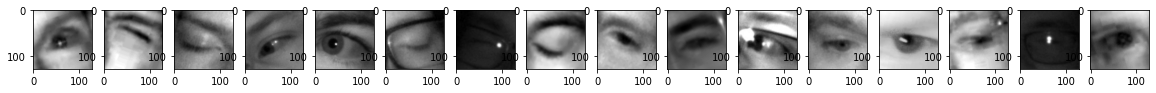

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i, data in enumerate(train_batches):
    imgs = data[0]
    labels = data[1]
    print(labels.numpy())
    f, ax = plt.subplots(1,BATCH_SIZE, figsize=(20,5))
    for j, img in enumerate(imgs):
        out_img = (img*255).numpy().astype(np.uint8)[:,:,0]
        ax[j].imshow(out_img, cmap='gray')
    plt.show()
    break

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
    include_top=False, 
    weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.2),
  
#   tf.keras.layers.Conv2D(64, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#   tf.keras.layers.Dropout(0.2),

  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer="adam",
    loss='binary_crossentropy',
    metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,626,689
Trainable params: 368,705
Non-

In [ ]:
mc = tf.keras.callbacks.ModelCheckpoint('weights{epoch:08d}.h5', 
    save_weights_only=True, period=5)

history = model.fit(
    train_batches, 
    epochs=50,
    validation_data=val_batches,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[mc],
)

Epoch 1/50
3608/3608 [==============================] - 223s 59ms/step - loss: 0.1843 - accuracy: 0.9298 - val_loss: 4.2843 - val_accuracy: 0.5053
Epoch 2/50
3608/3608 [==============================] - 208s 58ms/step - loss: 0.1319 - accuracy: 0.9505 - val_loss: 3.8760 - val_accuracy: 0.5055
Epoch 3/50
3608/3608 [==============================] - 207s 57ms/step - loss: 0.1192 - accuracy: 0.9562 - val_loss: 4.6111 - val_accuracy: 0.5058
Epoch 4/50
3608/3608 [==============================] - 211s 58ms/step - loss: 0.1134 - accuracy: 0.9574 - val_loss: 2.4931 - val_accuracy: 0.5355
Epoch 5/50
3608/3608 [==============================] - 207s 57ms/step - loss: 0.1050 - accuracy: 0.9602 - val_loss: 4.2688 - val_accuracy: 0.5079
Epoch 6/50
3608/3608 [==============================] - 206s 57ms/step - loss: 0.1031 - accuracy: 0.9615 - val_loss: 1.7889 - val_accuracy: 0.6232
Epoch 7/50
3608/3608 [==============================] - 215s 60ms/step - loss: 0.0986 - accuracy: 0.9630 - val_loss: 1

KeyboardInterrupt: ignored

In [ ]:
model.load_weights("weights00000010.h5")

dataset_test = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))
test_images = dataset_test.map(lambda x, y: load_image(x, y, IMAGE_SIZE, IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
from tqdm import tqdm

y_true = []
y_pred = []
for element in tqdm(test_images.as_numpy_iterator(), total=len(filenames_test)):
    image, label = element
    y_true.append(label)
    image = image / 255
    image_to_predict = image[None, :,:,:]
    output = model.predict(image_to_predict, verbose=0).squeeze()
    output = (output > 0.5).astype(int)
    y_pred.append(output)

100%|██████████| 16980/16980 [15:16<00:00, 18.52it/s]


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion matrix")
print(conf_mat)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='binary')
print("Precision", precision)
print("Recall", recall)
print("F1", f1)

Confusion matrix
[[8199  190]
 [ 306 8285]]
Precision 0.9775811209439528
Recall 0.9643813292981027
F1 0.9709363647017462


In [ ]:
!mkdir saved_models

saved_model_dir = 'saved_models' # Put the name of the directory where you want to save the model
tf.saved_model.save(model, saved_model_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
with open('eye.tflite', 'wb') as f:
  f.write(tflite_model)